In [1]:
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [4]:
logs = [
        f'/home/t9s9/Datasets/AudioSet/audioset_train_rest_download_report_round_{i}.json' for i in range(2)
]

status = []
for log_file in logs:
        with open(log_file, 'r') as f:
                status += json.load(f)['status_list']


failed = list(filter(lambda x: not x[1], status))
failed_ids = set(map(lambda x: x[0], failed))
len(failed_ids)

175861

In [5]:
root = Path('/home/t9s9/Datasets/AudioSet')

downloaded = (
        set((root / 'train').iterdir()) |
        set((root / 'data').iterdir())
)
downloaded = set(map(lambda x: x.name, downloaded))
len(downloaded)

1278386

In [6]:
df = pd.read_csv('/home/t9s9/PycharmProjects/YT-Dataset-Downloader/datasets/audioset_train.csv')

pattern = "{0}_{1:06}_{2:06}.mp4"
df['filename'] = df.apply(lambda row: pattern.format(row['youtube_id'], int(row['time_start']), int(row['time_end'])), axis=1)

In [7]:
exist = df[df.filename.isin(downloaded)]
assert len(exist) == len(downloaded)

In [8]:
remain = df[~df.filename.isin(downloaded)]
remain = remain.drop(columns='filename')
remain = remain[~df.youtube_id.isin(failed_ids)]
remain

/tmp/ipykernel_54695/386114834.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  remain = remain[~df.youtube_id.isin(failed_ids)]


,youtube_id,time_start,time_end
1207617,UctyrWq7DM0,20.0,30.0
1207618,Ucu-nzSkQas,0.0,10.0
1207619,Ucu12QP1L9E,160.0,170.0
1207620,Ucu1HlQWdDc,28.0,38.0
1207621,Ucu2dyFhs4I,30.0,40.0
...,...,...,...
2041784,zzyyleHsxfk,20.0,30.0
2041785,zzz-JsGPtxQ,120.0,130.0
2041786,zzz3PZXRQ_8,30.0,40.0
2041787,zzznDcamMpw,0.0,10.0


In [9]:
remain.to_csv('/home/t9s9/PycharmProjects/YT-Dataset-Downloader/datasets/audioset_train_rest.csv', index=False)

# Fail Analysis

In [14]:
def filters(x: str):
        x = x.replace("'", "").replace("\\n", "")[31:]
        if x.endswith('does not contain any stream"'):
                return 'corrupted stream'
        elif 'copyright' in x or 'contains content from' in x:
                return 'copyright'
        elif 'violating YouTubes' in x:
                return 'policy'
        elif 'Private video. Sign in if youve been granted access to this video' in x:
                return 'private'
        elif 'Video unavailable' in x:
                return  'unavailable'
        else:
                return x

def filter_unavailable(x: str):
        x = x.replace("'", "").replace("\\n", "")[31:]
        if 'Video unavailable' in x:
                return x
        else:
                return False


failed_reason = list(map(lambda x: filters(x[2]), failed))
unavailable_reason = list(map(lambda x: filter_unavailable(x[2]), failed))
set(failed_reason)

{' 1',
 ' This video is available to this channels members on level: VIP Member (or any higher level). Join this channel to get access to members-only content and other exclusive perks."',
 ' This video is available to this channels members on level: WORDPIE SUPPOTER (or any higher level). Join this channel to get access to members-only content and other exclusive perks."',
 ' Were processing this video. Check back later."',
 'Join this channel to get access to members-only content like this video, and other exclusive perks.',
 'Requested format is not available. Use --list-formats for a list of available formats',
 'Sign in to confirm your age. This video may be inappropriate for some users.',
 'This video is not available.',
 'This video is unavailable',
 'copyright',
 'corrupted stream',
 'ore this, add a trailing ? to the map."',
 'policy',
 'private',
 'unavailable'}

In [15]:
counter = Counter(failed_reason)
counter.most_common(10)

[('unavailable', 106481),
 ('private', 57227),
 ('copyright', 8062),
 ('policy', 3569),
 (' 1', 277),
 ('corrupted stream', 155),
 ('Sign in to confirm your age. This video may be inappropriate for some users.',
  47),
 ('Join this channel to get access to members-only content like this video, and other exclusive perks.',
  18),
 ('Requested format is not available. Use --list-formats for a list of available formats',
  14),
 (' Were processing this video. Check back later."', 4)]

In [12]:
plot_data = []

total = counter.total()
for name, occur in counter.items():
        if occur / total > 0.01:
                plot_data.append((name, occur))
plot_data

[('unavailable', 106481),
 ('private', 57227),
 ('policy', 3569),
 ('copyright', 8062)]

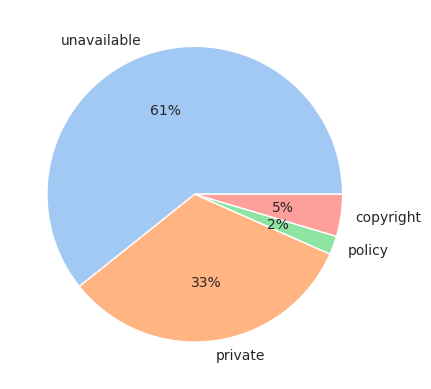

In [13]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]
labels, data = zip(*plot_data)
#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()